# Setup

In [865]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (16, 6)
mpl.rcParams['axes.grid'] = False

# Data

In [ ]:
# House price data for 2005 - 2019
uhp_csv = "https://landregistry.data.gov.uk/app/ukhpi/download/new.csv?from=2005-01-01&to=2019-12-01&location=http%3A%2F%2Flandregistry.data.gov.uk%2Fid%2Fregion%2Funited-kingdom&thm%5B%5D=property_type&in%5B%5D=avg"
# Read the data
df = pd.read_csv(uhp_csv)
# Drop unnecessary columns
df.drop(columns=["Name", "URI", "Region GSS code", "Reporting period",
                 "Pivotable date", "Average price All property types"], inplace = True)
df.head(5)

In [ ]:
# Take timesteps to their own array
dates = pd.to_datetime(df.pop('Period'), format='%Y-%m')

In [ ]:
# Visualise the data
plot_features = df
plot_features.index = dates
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

# Feaure Engineering

In [ ]:
# Identify perodicities which are useful for determining the sales volume
fft = tf.signal.rfft(df['Sales volume'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Sales volume'])
years_per_dataset = n_samples_h/12

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1.1e6)
plt.xlim([0.5, 30])
plt.xticks([1, 2, 4], labels=['1/Year', '1/Half-year', '1/Quarter'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
df["Year cos"] = [-np.cos(date.month * 2 * np.pi / 12) for date in dates]
df["Year sin"] = [-np.cos(date.month * 2 * np.pi / 12) for date in dates]

# Split & Normalise

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

# Train: 2005-2015
# Validation: 2016-2017
# Test: 2018-2019

n = len(df)
train_df = df[0:(12*11)]
val_df = df[(12*11):(12*13)]
test_df = df[(12*13):(12*15)]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=25)

# Window Generator

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, max_subplots=3, plot_col=""):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Month number')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [ ]:
window = WindowGenerator(input_width=23, label_width=23, shift=1,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_columns=['Sales volume'])

window.plot(plot_col="Sales volume")

# Baseline Model

In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['Sales volume'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(window.val)
performance['Baseline'] = baseline.evaluate(window.test, verbose=0)

window.plot(baseline, plot_col="Sales volume")

# RNN

In [ ]:
MAX_EPOCHS = 1000

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min',
                                                     restore_best_weights=False)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS, 
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
tf.keras.backend.clear_session()
history = compile_and_fit(lstm_model, window, patience=100)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(window.val)
performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0)

In [ ]:
window.plot(lstm_model, plot_col="Sales volume")

# Comparison

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'root_mean_squared_error'
metric_index = lstm_model.metrics_names.index('root_mean_squared_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('RMSE [Sales volume]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# Towards DS Method

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tqdm.keras import TqdmCallback

In [ ]:
df.head(1)

In [ ]:
history_steps = 35
prediction_steps = 1
target_col = "Sales volume"
ar_cols = ["Average price Detached houses", "Average price Semi-detached houses", "Average price Terraced houses",
          "Average price Flats and maisonettes", "Year cos", "Year sin", "Sales volume"]

In [ ]:
def reshape_ts(df = df, history_steps = 35, prediction_steps = 1, target_col = "Sales volume"):
    df_transform = []
    for t in range(len(df) - history_steps):
        df_transform.append(df[t:(t + history_steps + 1)][target_col].reset_index(drop=True, inplace=False))

    df_transform = pd.DataFrame(df_transform)
    return df_transform

In [ ]:
train_end = pd.to_datetime('20111231', format='%Y%m%d')
val_end = pd.to_datetime('20151231', format='%Y%m%d')
test_end = pd.to_datetime('20191231', format='%Y%m%d')

df_train = df[df.index < train_end]
df_val = df[(df.index > train_end) & (df.index < val_end)]
df_test = df[(df.index > val_end) & (df.index < test_end)]

df_train = reshape_ts(df_train,
                      history_steps = history_steps,
                      prediction_steps = prediction_steps)
df_val = reshape_ts(df_val,
                    history_steps = history_steps,
                    prediction_steps = prediction_steps)
df_test = reshape_ts(df_test,
                     history_steps = history_steps,
                     prediction_steps = prediction_steps)

print("Number of training rows: ", len(df_train))
print("Number of validation rows: ", len(df_val))
print("Number of test rows: ", len(df_test))

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_train)

df_train = pd.DataFrame(scaler.transform(df_train))
df_val = pd.DataFrame(scaler.transform(df_val))
df_test = pd.DataFrame(scaler.transform(df_test))

In [ ]:
col_names = [f'x_lag{i}' for i in range(history_steps)] + ['y']
df_train.columns = col_names
df_val.columns = col_names
df_test.columns = col_names

df_train.head(1)

In [ ]:
# Create the Keras model.
# Use hyperparameter optimization if you have the time.

ts_inputs = tf.keras.Input(shape=(history_steps, 1))

# units=10 -> The cell and hidden states will be of dimension 10.
#             The number of parameters that need to be trained = 4*units*(units+2)
x = tf.keras.layers.LSTM(units=10)(ts_inputs)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [ ]:
# Specify the training configuration.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.metrics.RootMeanSquaredError()])

model.summary()

In [ ]:
# train in batch sizes of 128.
#BATCH_SIZE = 10
NUM_EPOCHS = 10000

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, mode='min',
                                                  restore_best_weights=True)

model.fit(x=df_train.drop('y', axis=1).values,
          y=df_train["y"].values,
          #batch_size=BATCH_SIZE,
          validation_data = (df_val.drop('y', axis=1).values, df_val["y"].values),
          verbose=0,
          callbacks=[TqdmCallback(verbose=1), early_stopping],
          epochs=NUM_EPOCHS)

In [ ]:
model.evaluate(df_test.drop('y', axis=1).values, df_test["y"].values)

In [ ]:
df_plot_test = df[(df.index > val_end) & (df.index < test_end)][["Sales volume"]]
test_predictions = df_test.drop('y', axis=1)
test_predictions["y"] = model.predict(test_predictions)
df_plot_test["Predictions"] = None

df_plot_test.iloc[history_steps:, 1] = [pred[-1] for pred in scaler.inverse_transform(test_predictions)]

df_plot_test

In [ ]:
df_plot_test.plot()

## Multiple Predictors

In [ ]:
from sklearn.model_selection import train_test_split

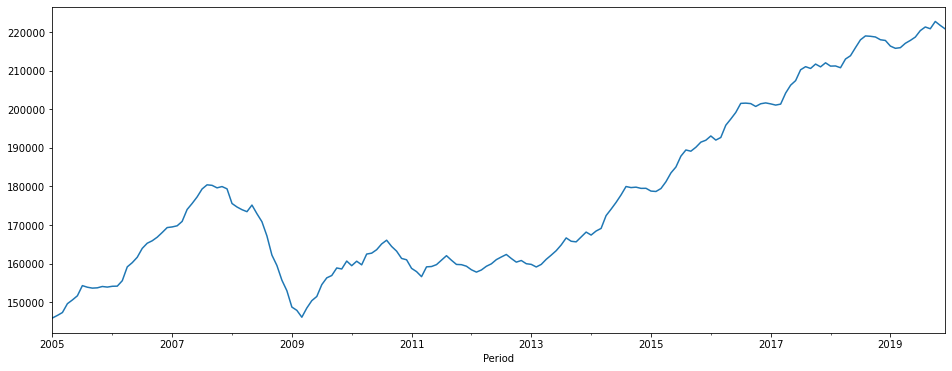

In [866]:
df["Average price Semi-detached houses"].plot()

In [848]:
history_steps = 24
target_col = "Average price Semi-detached houses"
ar_cols = ["Average price Semi-detached houses", "Year cos", "Year sin", "Sales volume", "month"]

In [850]:
df_with_index = df
df_with_index["month"] = range(len(df))

In [851]:
df_X_train, df_X_val, df_y_train, df_y_val = train_test_split(df_with_index, df[target_col],
                                                              test_size=0.5, shuffle=False)
df_X_val, df_X_test, df_y_val, df_y_test = train_test_split(df_X_val, df_y_val, test_size=0.5, shuffle=False)

In [834]:
def format_ts(df_x, df_y):
    x_vals = []
    y_vals = []

    i = 0
    rows_remaining = len(df_x)
    while rows_remaining >= history_steps + 2:
        x_vals.append(df_x[i:i + history_steps][ar_cols].values.tolist())
        y_vals.append(df_y[i + history_steps + 1])
        i += 1
        rows_remaining = len(df_x[i:])

    x_vals = np.asarray(x_vals)
    return x_vals, y_vals

In [838]:
def scale_x_y(x, y, scaler_x=None, scaler_y=None):
    if scaler_x is None:
        scaler_x = MinMaxScaler()
        x_scale = scaler_x.fit(
            x.reshape(x.shape[0], x.shape[1] * x.shape[2]))
    x_scale = scaler_x.transform(
        x.reshape(x.shape[0], x.shape[1] * x.shape[2])).reshape(
        x.shape)
    if scaler_y is None:
        scaler_y = MinMaxScaler()
        y_scale = scaler_y.fit([[i_y] for i_y in y])
    y_scale = scaler_y.transform([[i_y] for i_y in y])

    return scaler_x, scaler_y, x_scale, np.asarray([y[0] for y in y_scale])

In [852]:
X_train, y_train = format_ts(df_X_train, df_y_train)
X_val, y_val = format_ts(df_X_val, df_y_val)
X_test, y_test = format_ts(df_X_test, df_y_test)

scaler_x, scaler_y, X_train, y_train = scale_x_y(X_train, y_train)

_, _, X_val, y_val = scale_x_y(X_val, y_val, scaler_x=scaler_x, scaler_y=scaler_y)
_, _, X_test, y_test = scale_x_y(X_test, y_test, scaler_x=scaler_x, scaler_y=scaler_y)

In [853]:
# Create the Keras model.
# Use hyperparameter optimization if you have the time.

ts_inputs_multi = tf.keras.Input(shape=(history_steps, len(ar_cols)))

# units=10 -> The cell and hidden states will be of dimension 10.
#             The number of parameters that need to be trained = 4*units*(units+2)
outputs_multi = tf.keras.layers.LSTM(units=10)(ts_inputs_multi)
outputs_multi = tf.keras.layers.Dropout(0.4)(outputs_multi)
outputs_multi = tf.keras.layers.Dense(1, activation='linear')(outputs_multi)
multi_model = tf.keras.Model(inputs=ts_inputs_multi, outputs=outputs_multi)

In [854]:
# Specify the training configuration.
multi_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.metrics.RootMeanSquaredError()])

multi_model.summary()

Model: "functional_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 24, 5)]           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 10)                640       
_________________________________________________________________
dropout_20 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 11        
Total params: 651
Trainable params: 651
Non-trainable params: 0
_________________________________________________________________


In [855]:
# train in batch sizes of 128.
#BATCH_SIZE = 10
NUM_EPOCHS_MULTI = 10000

early_stopping_multi = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min',
                                                        restore_best_weights=True)

history = multi_model.fit(x=X_train,
                          y=y_train,
                          #batch_size=BATCH_SIZE,
                          validation_data = (X_val, y_val),
                          verbose=0,
                          callbacks=[TqdmCallback(verbose=1), early_stopping],
                          epochs=NUM_EPOCHS_MULTI)

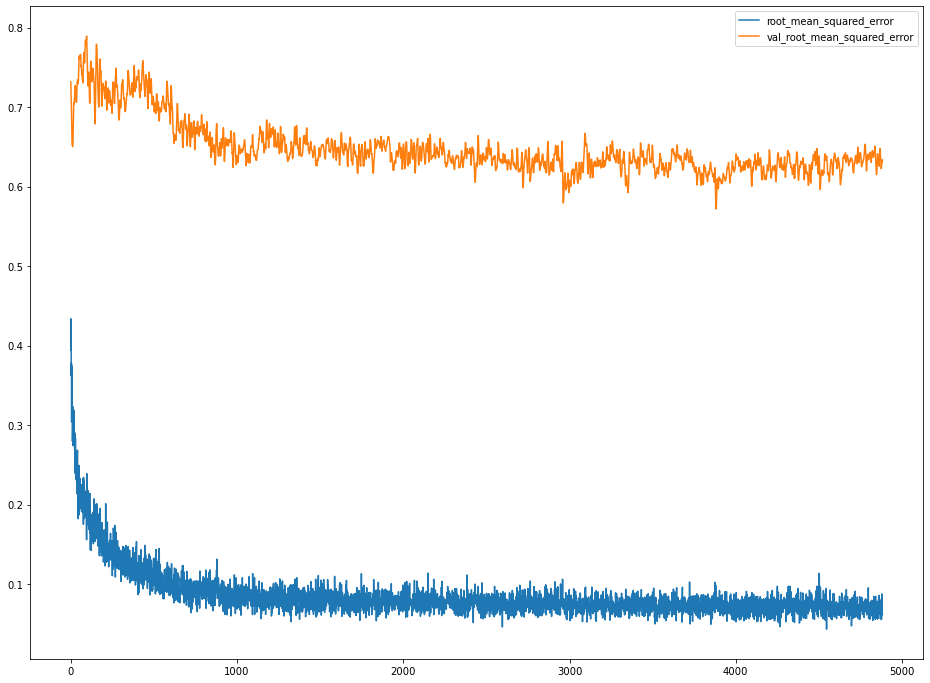

In [856]:
pd.DataFrame(history.history)[["root_mean_squared_error", "val_root_mean_squared_error"]].plot()

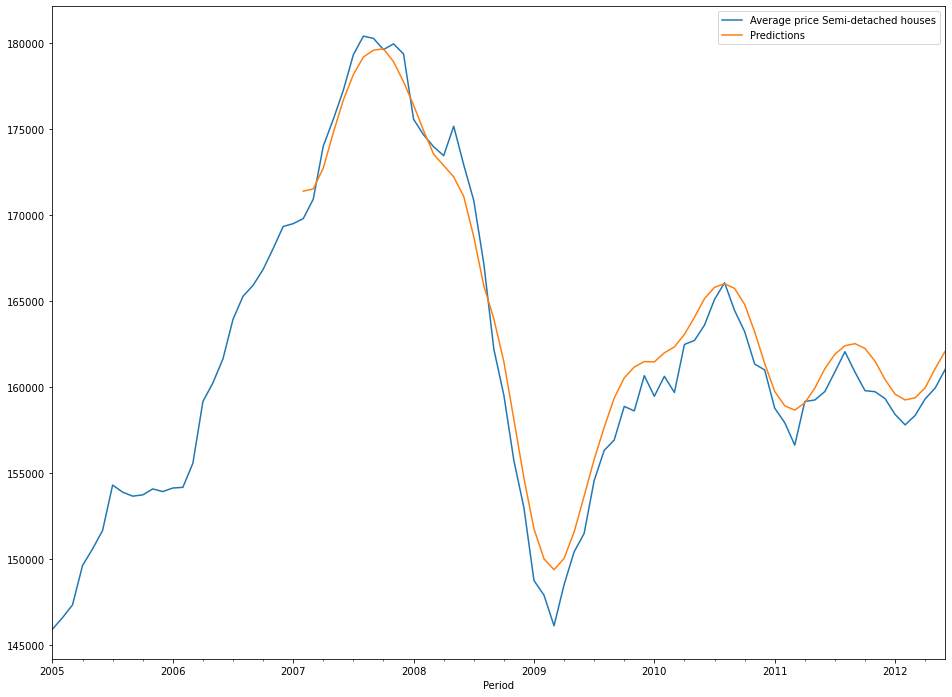

In [857]:
pred_train = scaler_y.inverse_transform(multi_model.predict(X_train))
eval_train = pd.DataFrame(df_y_train)
eval_train["Predictions"] = None
eval_train.iloc[history_steps + 1:, 1] = pred_train
eval_train.plot()

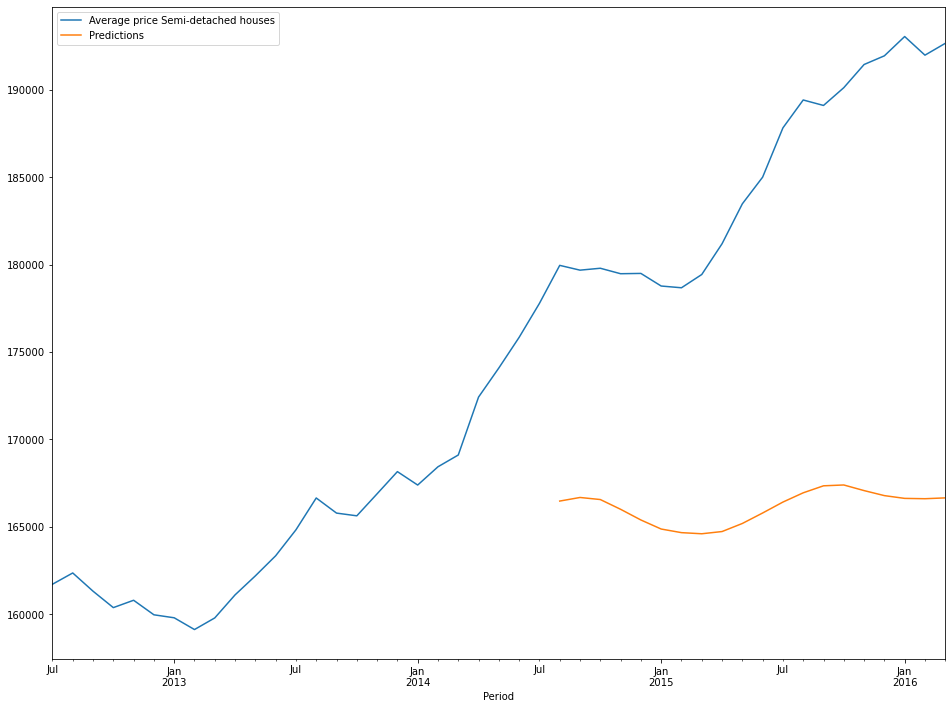

In [858]:
pred_val = scaler_y.inverse_transform(multi_model.predict(X_val))
eval_val = pd.DataFrame(df_y_val)
eval_val["Predictions"] = None
eval_val.iloc[history_steps + 1:, 1] = pred_val
eval_val.plot()

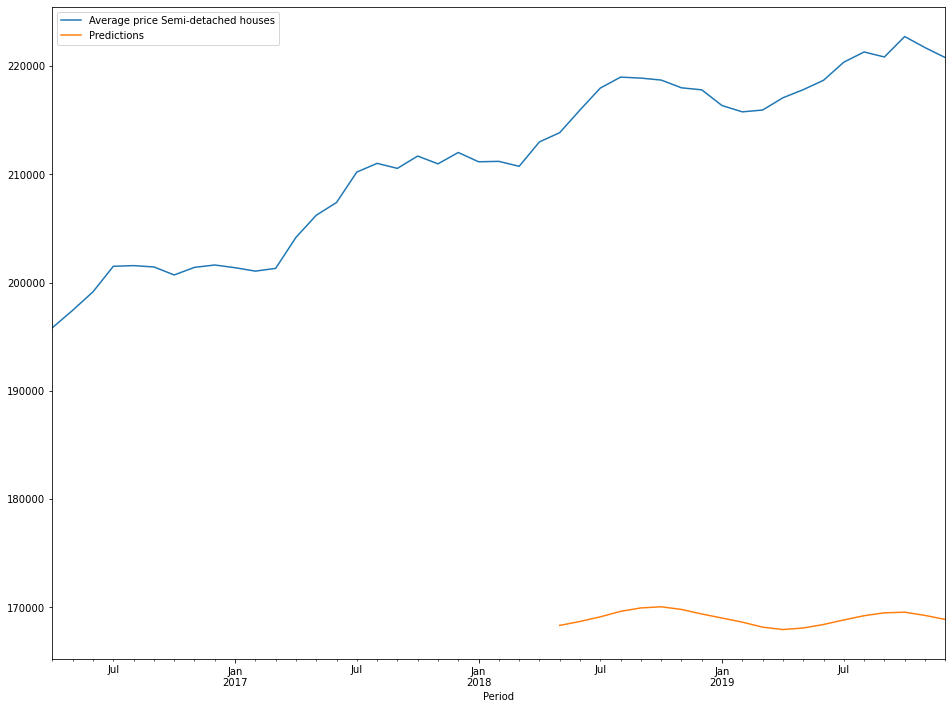

In [859]:
pred_test = scaler_y.inverse_transform(multi_model.predict(X_test))
eval_test = pd.DataFrame(df_y_test)
eval_test["Predictions"] = None
eval_test.iloc[history_steps + 1:, 1] = pred_test
eval_test.plot()